# Checking DSW

This notebook is designed to compare a series of runs with ACCESS-OM2-01 that we are conducting to understand why we have suddenly lost DSW in our latest RYF simulations.

Runs include:

| Run Name  | Notes 
|:-----------|-------
|01deg_jra55v13_ryf8485_spinup6  |  Original run which did have DSW it goes from year 0-37, then 1937-1948
|01deg_jra55v13_ryf8485_spinup7  |  First attempted rerun, in which DSW disappeared. 1900-1920. Many differences from spinup6...
|01deg_jra55v13_ryf8485_spinup9  |  Same as spinup7, reverting back to potential temperature. 1900-1908.
|01deg_jra55v13_ryf8485_spinup10 |  Same as spinup7,reverting back to original salt restoring file. 1900-1910.
|01deg_jra55v13_ryf8485_spinup11 |  Same as spinup7, turning of J09 diffusivity. 1900-1913.
|01deg_jra55v13_ryf8485_spinup12 |  Same as spinup7, adding ice turning angle back into CICE. 1900-1905.
|01deg_jra55v13_ryf8485_spinup6_newexe | Kicking off from near the end of spinup6, but using spinup7 executable. 1945-1948 (so far)
|01deg_jra55v13_ryf8485_spinup6_newexe_highfreq | Kicking off from spinup6, spinup7 executable with `highfreq=true`. 1945-1947 (so far)

Note that because some experiments start at 1900 from WOA13, and other experiments branch from spinup6 at 1945, we analyse each set of experiments separately.

In [15]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cftime
from dask.distributed import Client
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
db = '/g/data3/hh5/tmp/cosima/database/access-om2.db'

**Start up a client** (required to build the index):

In [3]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:43223 Dashboard: http://127.0.0.1:39586/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


**Rebuild the database**:

In [4]:
dir_list=['/g/data3/hh5/tmp/cosima/access-om2-01',
          '/g/data3/hh5/tmp/cosima/access-om2-025',
          '/g/data3/hh5/tmp/cosima/access-om2']
cc.database.build_index(dir_list,client,db,update=True)

66/66

# Drake Passage Transport

In [5]:
xmin=-69.9
ymin=-71.6
ymax=-51.0

01deg_jra55v13_ryf8485_spinup7
01deg_jra55v13_ryf8485_spinup9
01deg_jra55v13_ryf8485_spinup10
01deg_jra55v13_ryf8485_spinup11
01deg_jra55v13_ryf8485_spinup12


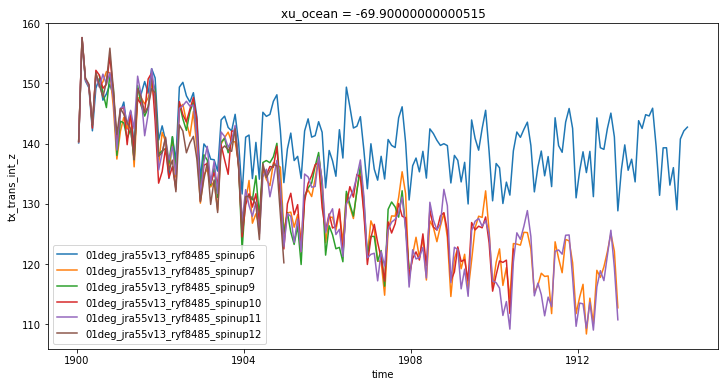

In [41]:
plt.figure(figsize=(12,6))
expt = '01deg_jra55v13_ryf8485_spinup6'
tx_trans = cc.querying.getvar(expt,'tx_trans_int_z',db,offset=693135,
                            time_units='days since 1900-01-01',n=150)
transport6 = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')/1e6/1036
transport6.plot(label=expt)


expt_list_1 = ['01deg_jra55v13_ryf8485_spinup7',
             '01deg_jra55v13_ryf8485_spinup9',
             '01deg_jra55v13_ryf8485_spinup10',
             '01deg_jra55v13_ryf8485_spinup11',
             '01deg_jra55v13_ryf8485_spinup12']
for expt in expt_list_1:
    print(expt)
    tx_trans = cc.querying.getvar(expt,'tx_trans_int_z',db)
    transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')/1e6/1036
    transport.plot(label=expt)
plt.legend()

01deg_jra55v13_ryf8485_spinup6_newexe_highfreq
01deg_jra55v13_ryf8485_spinup6_newexe


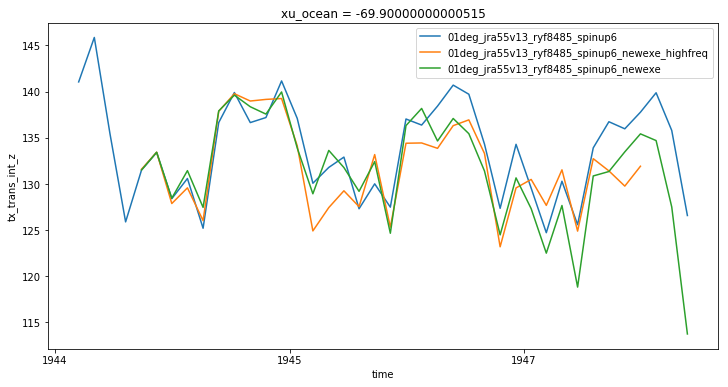

In [42]:
plt.figure(figsize=(12,6))
expt = '01deg_jra55v13_ryf8485_spinup6'
tx_trans = cc.querying.getvar(expt,'tx_trans_int_z',db,n=-20)
transport6 = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')/1e6/1036
transport6.plot(label=expt)


expt_list_2 = [
             '01deg_jra55v13_ryf8485_spinup6_newexe_highfreq',
             '01deg_jra55v13_ryf8485_spinup6_newexe']
for expt in expt_list_2:
    print(expt)
    tx_trans = cc.querying.getvar(expt,'tx_trans_int_z',db)
    transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')/1e6/1036
    transport.plot(label=expt)
plt.legend()



## Shelf density
We can show that the main difference between spinup6 and spinup7 is the lack of Dense Shelf Water forming in the latter case. This difference is clearly visible by the 4th year of the experiment. This is highlighted in the following plots, which show that the iterations of spinup9-spinup12 do very little to change this...

Calculating density for Year  4
CPU times: user 57 s, sys: 11.1 s, total: 1min 8s
Wall time: 2min 2s


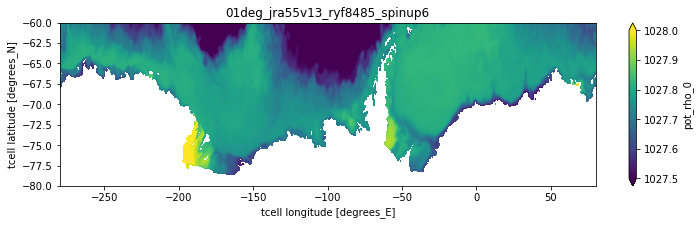

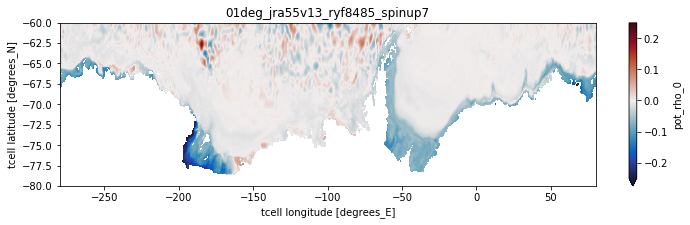

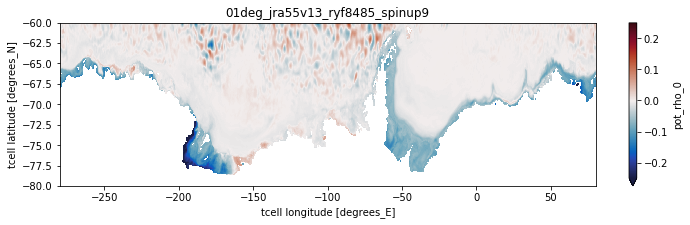

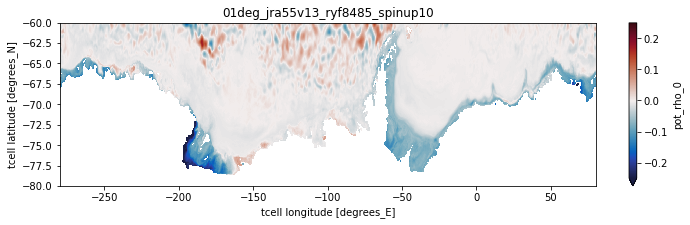

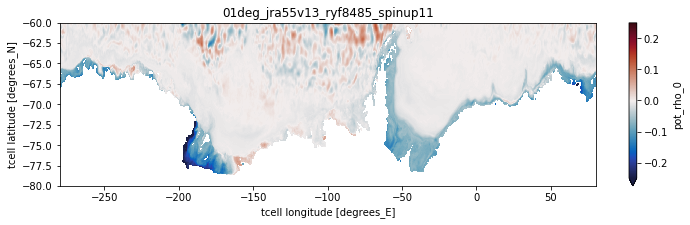

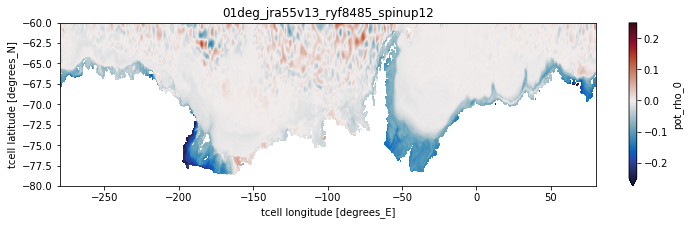

In [43]:
year = 4
zlevel = 350
print('Calculating density for Year ',year)
plt.figure(figsize=(12,3))
expt='01deg_jra55v13_ryf8485_spinup6'
rho = cc.querying.getvar(expt,'pot_rho_0',db).sel(st_ocean = zlevel,method='nearest')
rho = rho.sel(yt_ocean=slice(-80,-60)).sel(time=slice(cftime.DatetimeNoLeap(year,1,1),cftime.DatetimeNoLeap(year,12,31)))
rho6=rho.mean('time')
rho6.plot(vmin=1027.5,vmax=1028)
plt.title(expt)
for expt in expt_list_1:
    rho = cc.querying.getvar(expt,'pot_rho_0',db).sel(st_ocean = zlevel,method='nearest')
    rho = rho.sel(yt_ocean=slice(-80,-60)).sel(time=slice(cftime.DatetimeNoLeap(1899+year,1,1),cftime.DatetimeNoLeap(1899+year,12,31)))
    rho = rho.mean('time') - rho6
    plt.figure(figsize=(12,3))
    rho.plot(vmin=-.25,vmax=.25,cmap=cm.cm.balance)
    plt.title(expt)

## Ross Sea Salinity
We can refine our diagnostics even further, to look at salinity just on the Ross Sea Shelf.

Calculating salinity for Year  4


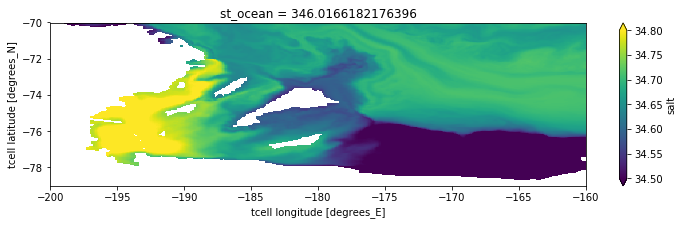

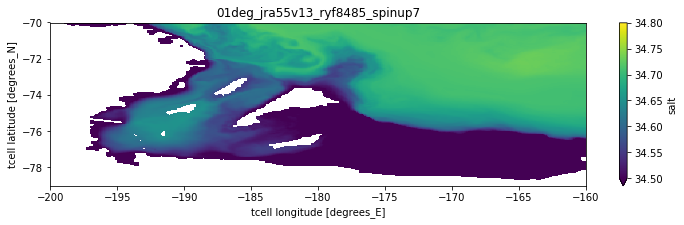

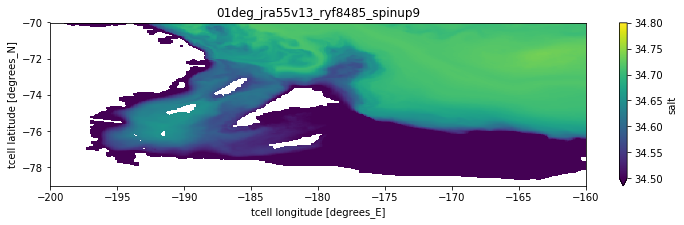

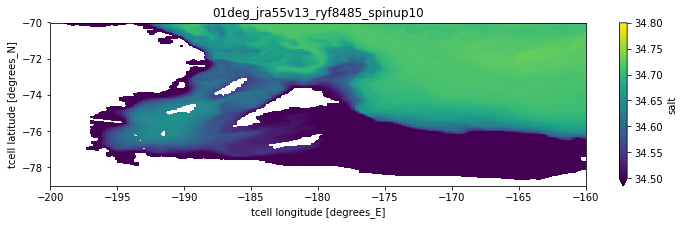

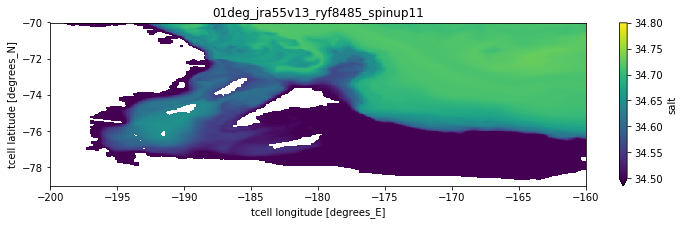

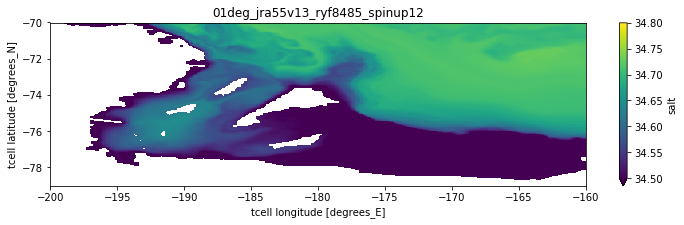

In [44]:
year = 4
zlevel = 350
print('Calculating salinity for Year ',year)
plt.figure(figsize=(12,3))
expt='01deg_jra55v13_ryf8485_spinup6'
salt = cc.querying.getvar(expt,'salt',db,n=100).sel(st_ocean = zlevel,method='nearest')
salt = salt.sel(yt_ocean=slice(-79,-70)).sel(xt_ocean=slice(-200,-160)).sel(time=slice(cftime.DatetimeNoLeap(year,1,1),cftime.DatetimeNoLeap(year,12,31)))
salt=salt.mean('time')
salt.plot(vmin=34.5,vmax=34.8)

for expt in expt_list_1:
    salt = cc.querying.getvar(expt,'salt',db).sel(st_ocean = zlevel,method='nearest')
    salt = salt.sel(yt_ocean=slice(-79,-70)).sel(xt_ocean=slice(-200,-160)).sel(time=slice(cftime.DatetimeNoLeap(1899+year,1,1),cftime.DatetimeNoLeap(1899+year,12,31)))
    salt = salt.mean('time')
    plt.figure(figsize=(12,3))
    s1=salt.plot(vmin=34.5,vmax=34.8)
    plt.title(expt)

Calculating salinity for Year  1945


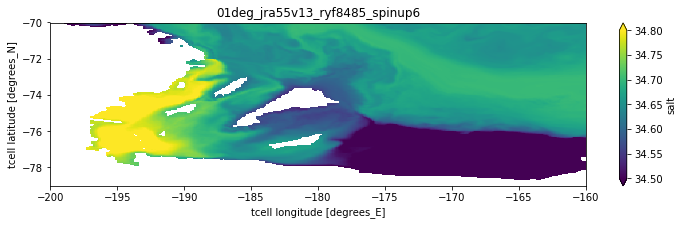

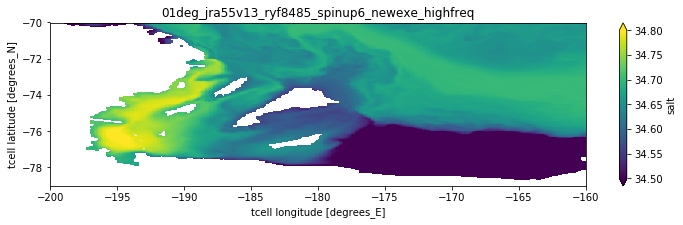

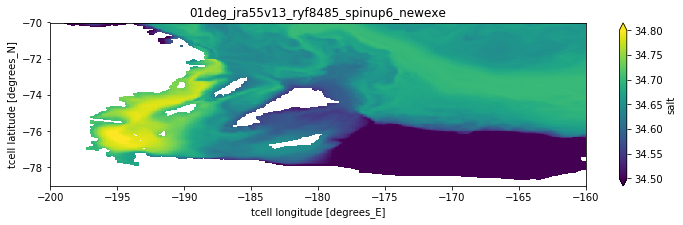

In [45]:
year = 1945
zlevel = 350
print('Calculating salinity for Year ',year)
plt.figure(figsize=(12,3))
expt='01deg_jra55v13_ryf8485_spinup6'
salt = cc.querying.getvar(expt,'salt',db,start_time='1945-01-01',end_time='1945-31-12').sel(st_ocean = zlevel,method='nearest')
salt = salt.sel(yt_ocean=slice(-79,-70)).sel(xt_ocean=slice(-200,-160)).sel(time=slice(cftime.DatetimeNoLeap(year,1,1),cftime.DatetimeNoLeap(year,12,31)))
salt=salt.mean('time')
salt.plot(vmin=34.5,vmax=34.8)
plt.title(expt)

for expt in expt_list_2:
    salt = cc.querying.getvar(expt,'salt',db).sel(st_ocean = zlevel,method='nearest')
    salt = salt.sel(yt_ocean=slice(-79,-70)).sel(xt_ocean=slice(-200,-160)).sel(time=slice(cftime.DatetimeNoLeap(year,1,1),cftime.DatetimeNoLeap(year,12,31)))
    salt = salt.mean('time')
    plt.figure(figsize=(12,3))
    s1=salt.plot(vmin=34.5,vmax=34.8)
    plt.title(expt)

Calculating salinity for Year  1946


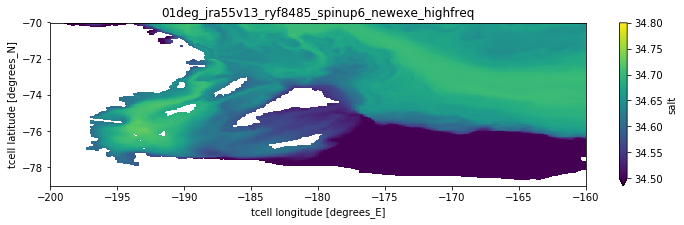

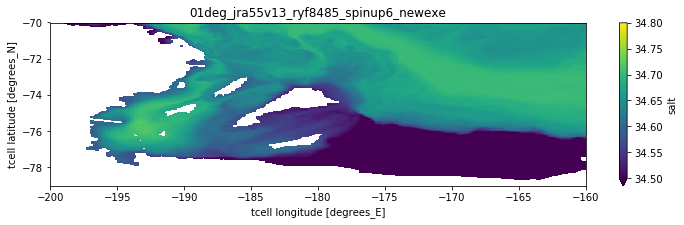

In [46]:
year = 1946
zlevel = 350
print('Calculating salinity for Year ',year)

for expt in expt_list_2:
    salt = cc.querying.getvar(expt,'salt',db).sel(st_ocean = zlevel,method='nearest')
    salt = salt.sel(yt_ocean=slice(-79,-70)).sel(xt_ocean=slice(-200,-160)).sel(time=slice(cftime.DatetimeNoLeap(year,1,1),cftime.DatetimeNoLeap(year,12,31)))
    salt = salt.mean('time')
    plt.figure(figsize=(12,3))
    s1=salt.plot(vmin=34.5,vmax=34.8)
    plt.title(expt)

## Salinity timeseries
Just take a timeseries of salinity at 350 m depth in a corner of the Ross Sea. Note that, for some reason, I can't load salt files from spinup6 from 1946.

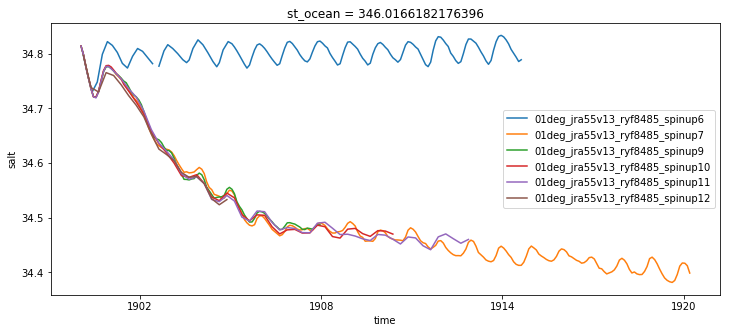

In [48]:
plt.figure(figsize=(12,5))
expt='01deg_jra55v13_ryf8485_spinup6'
salt = cc.querying.getvar(expt,'salt',db,offset=693135,
                            time_units='days since 1900-01-01',n=150).sel(st_ocean = zlevel,method='nearest')
salt = salt.sel(yt_ocean=slice(-78,-74)).sel(xt_ocean=slice(-195,-190)).mean('yt_ocean').mean('xt_ocean')
salt.plot(label=expt)

for expt in expt_list_1:
    salt = cc.querying.getvar(expt,'salt',db).sel(st_ocean = zlevel,method='nearest')
    salt = salt.sel(yt_ocean=slice(-78,-74)).sel(xt_ocean=slice(-195,-190)).mean('yt_ocean').mean('xt_ocean')
    salt.plot(label=expt)
plt.legend()

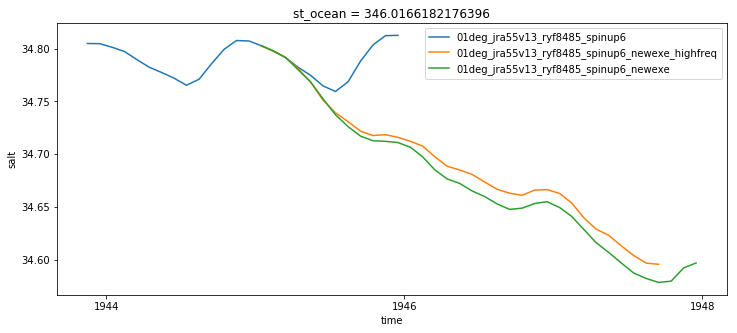

In [47]:
plt.figure(figsize=(12,5))
expt='01deg_jra55v13_ryf8485_spinup6'
salt = cc.querying.getvar(expt,'salt',db,start_time='1944-01-01',end_time='1945-31-12').sel(st_ocean = zlevel,method='nearest')
salt = salt.sel(yt_ocean=slice(-78,-74)).sel(xt_ocean=slice(-195,-190)).mean('yt_ocean').mean('xt_ocean')
salt.plot(label=expt)

for expt in expt_list_2:
    salt = cc.querying.getvar(expt,'salt',db).sel(st_ocean = zlevel,method='nearest')
    salt = salt.sel(yt_ocean=slice(-78,-74)).sel(xt_ocean=slice(-195,-190)).mean('yt_ocean').mean('xt_ocean')
    salt.plot(label=expt)
plt.legend()